In [ ]:
import numpy as np
import os
import cv2
import h5py

import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras
import tensorflow as tf

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


def unet(input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(inputs)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(pool1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(pool2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(pool3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv4)

    drop4 = Dropout(0.5)(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same',
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same',
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)

    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))

    merge6 = concatenate([drop4,up6])

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))

    merge7 = concatenate([conv3,up7])

    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)

    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)


    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))

    merge8 = concatenate([conv2,up8])

    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)

    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))

    merge9 = concatenate([conv1,up9])

    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)

    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)

    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])


    return model

In [ ]:
!cp /content/drive/MyDrive/ml-labs/Dataset_train.h5 /content
!cp /content/drive/MyDrive/ml-labs/Dataset_test.h5 /content

In [ ]:
print('*'*30)
print('Loading and preprocessing train data...')
print('*'*30)
file = h5py.File('Dataset_train.h5', 'r')
img_train = file.get('images')
mask_train = file.get('masks')
img_train = np.array(img_train)
mask_train = np.array(mask_train)

img_train = img_train.astype('float32')
img_train /= 255

mask_train = mask_train.astype('float32')
mask_train /= 255  # scale masks to [0, 1]

print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = unet()

******************************
Loading and preprocessing train data...
******************************
******************************
Creating and compiling model...
******************************


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
import tensorflow as tf
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
print('*'*30)
print('Fitting model...')
print('*'*30)

epochs = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(f'weights_bceloss_{epochs}epochs.h5', monitor='val_loss', save_best_only=True)

with tf.device("/GPU:0"):
  history =  model.fit(img_train, mask_train, batch_size=16, epochs=epochs, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint, early_stopping])

******************************
Fitting model...
******************************
Epoch 1/20
105/105 [==============================] - 128s 1s/step - loss: 0.2693 - dice_coef: 0.2786 - iou_coef: 0.1467 - val_loss: 0.2480 - val_dice_coef: 0.2774 - val_iou_coef: 0.1365
Epoch 2/20
105/105 [==============================] - 134s 1s/step - loss: 0.2379 - dice_coef: 0.3390 - iou_coef: 0.1860 - val_loss: 0.2077 - val_dice_coef: 0.3499 - val_iou_coef: 0.1796
Epoch 3/20
105/105 [==============================] - 132s 1s/step - loss: 0.2060 - dice_coef: 0.4016 - iou_coef: 0.2305 - val_loss: 0.1895 - val_dice_coef: 0.3897 - val_iou_coef: 0.2052
Epoch 4/20
105/105 [==============================] - 132s 1s/step - loss: 0.1910 - dice_coef: 0.4336 - iou_coef: 0.2569 - val_loss: 0.1788 - val_dice_coef: 0.4169 - val_iou_coef: 0.2279
Epoch 5/20
105/105 [==============================] - 132s 1s/step - loss: 0.1797 - dice_coef: 0.4593 - iou_coef: 0.2764 - val_loss: 0.1758 - val_dice_coef: 0.4182 - val_iou

In [ ]:
file = h5py.File('Dataset_test.h5', 'r')
img_test = file.get('images')
mask_test = file.get('masks')
img_test = np.array(img_test)
mask_test = np.array(mask_test)
img_test = img_test.astype('float32')

img_test /= 255

print('*'*30)
print('Loading saved weights...')
print('*'*30)
#model.load_weights('weights.h5')

print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
mask_pred = model.predict(img_test, verbose=1)

******************************
Loading saved weights...
******************************
******************************
Predicting masks on test data...
******************************
1/1 [==============================] - 15s 15s/step


In [ ]:
print('*' * 30)
print('Saving predicted masks to files...')
print('*' * 30)
pred_dir = 'Preds2'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for i, image in enumerate(mask_test):
    image = (image * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(pred_dir, str(i + 1) + '_pred.png'), image)

******************************
Saving predicted masks to files...
******************************


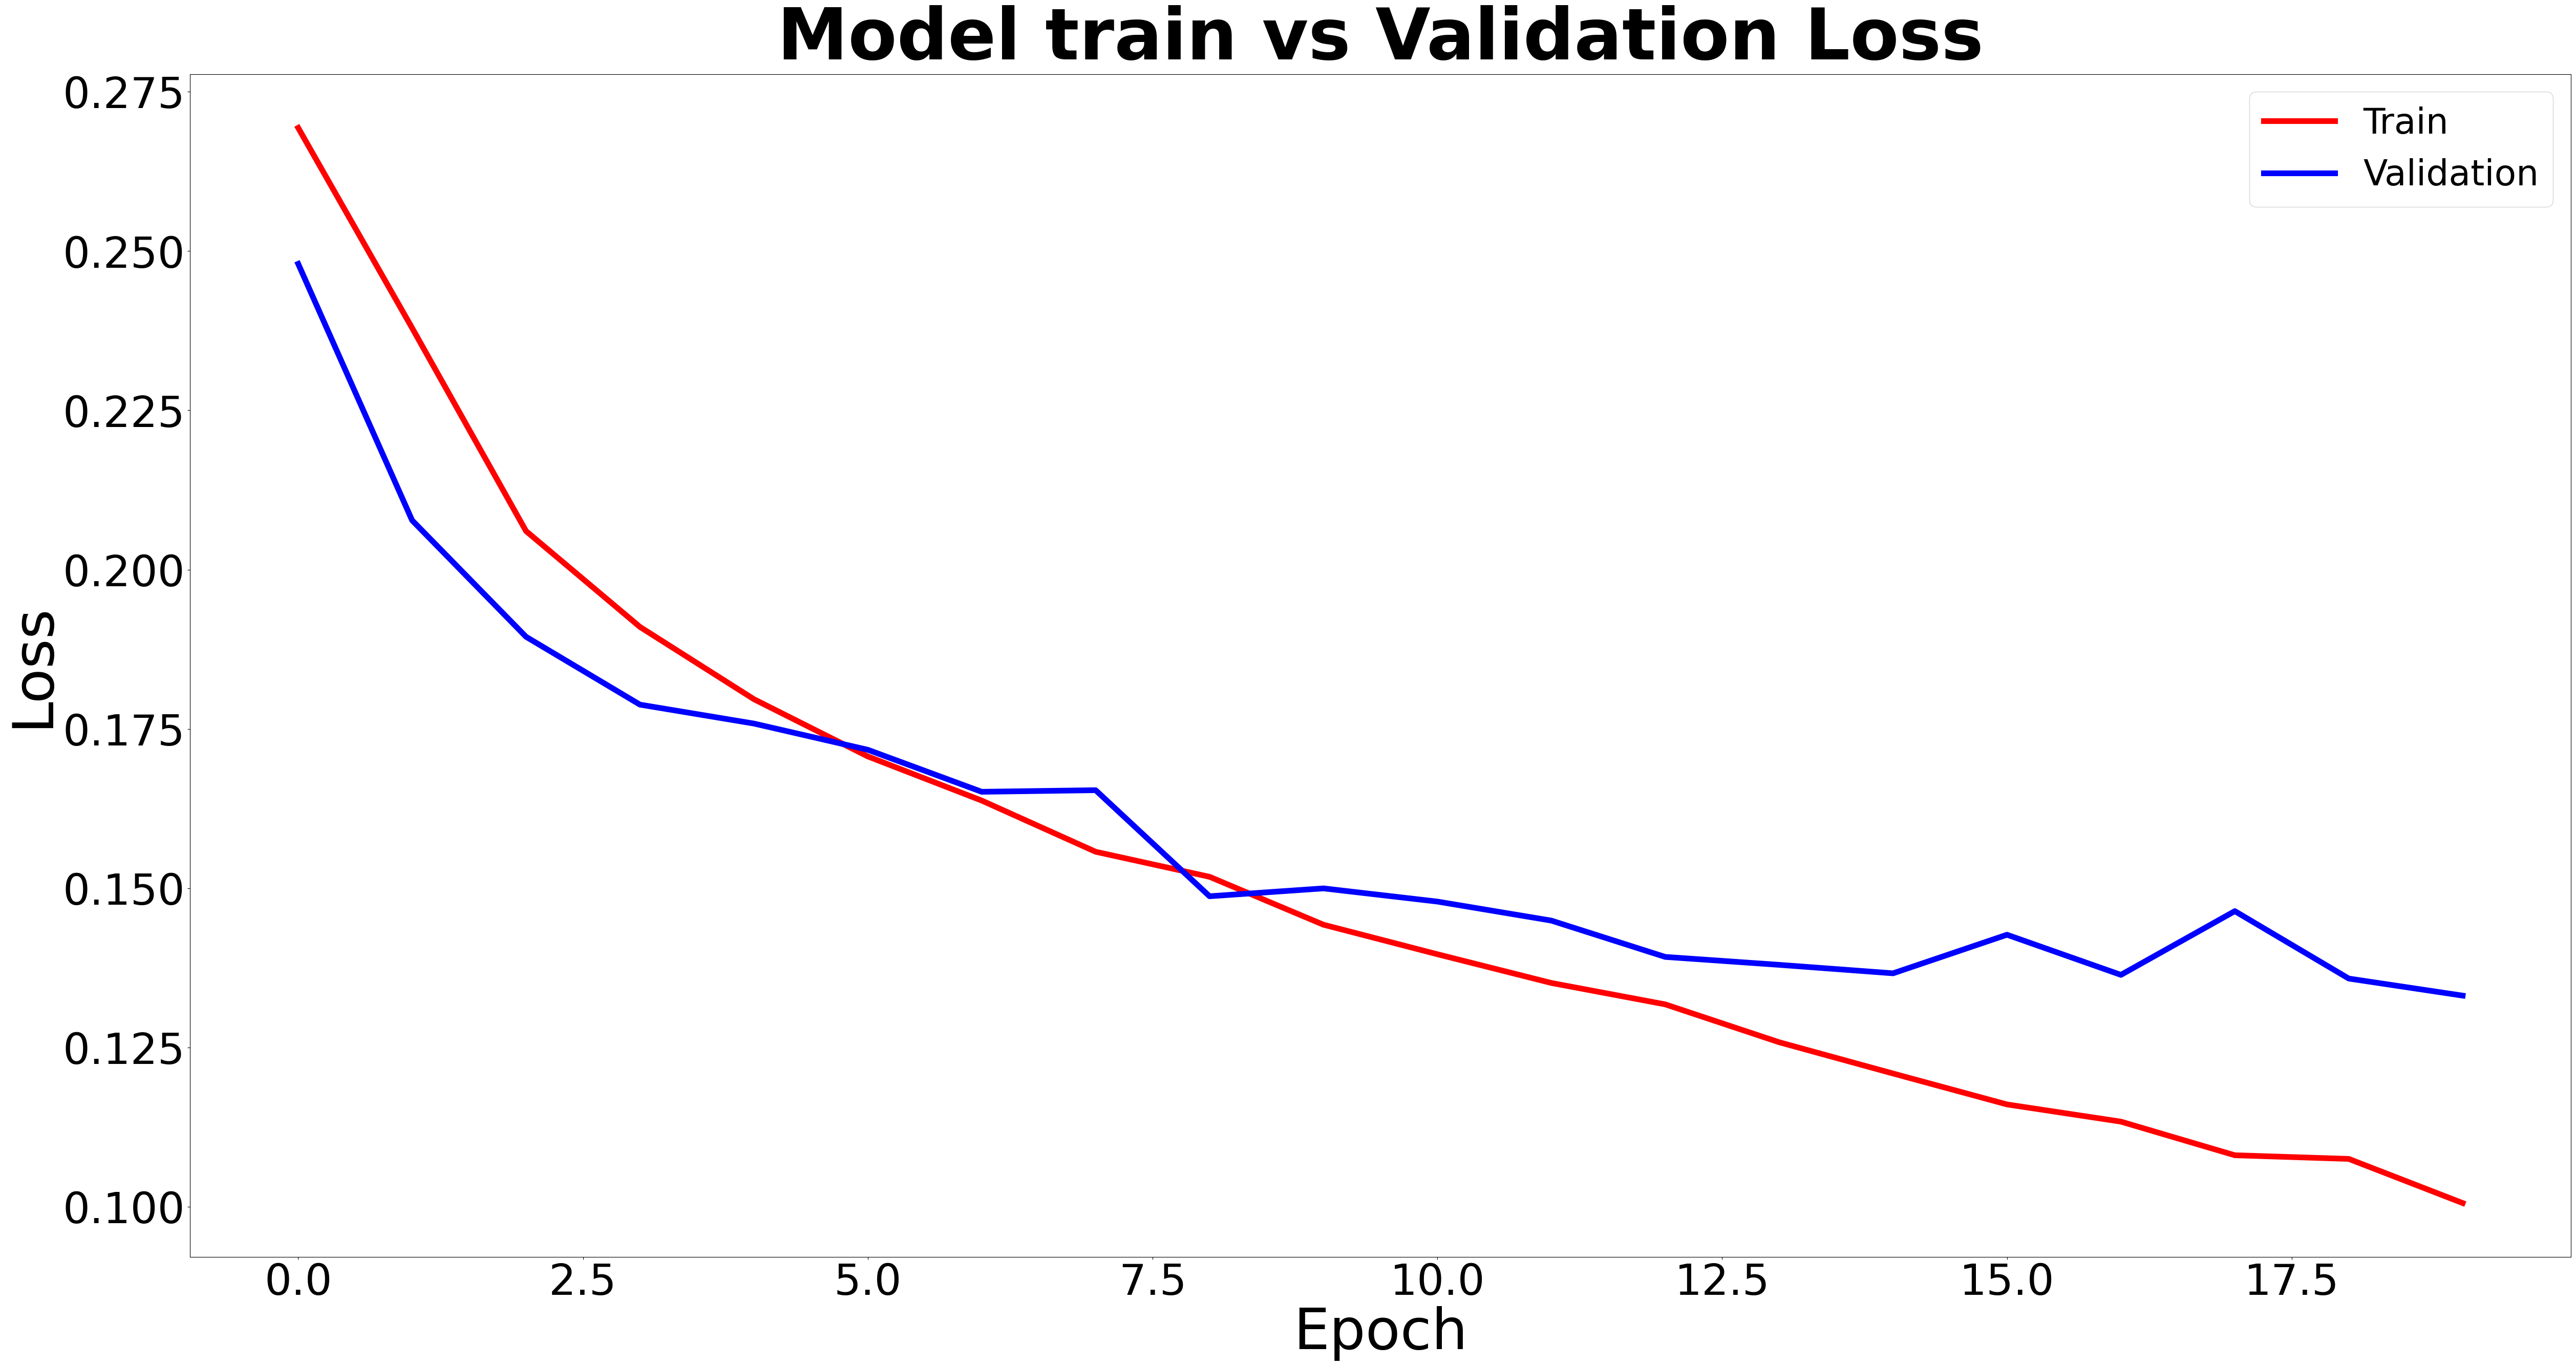

In [ ]:
plt.figure(figsize=(60, 30))
plt.plot(history.history['loss'], linewidth=8, color='r')                   #visualising training and validation loss curves
plt.plot(history.history['val_loss'], linewidth=8, color='b')
plt.title('Model train vs Validation Loss', fontsize=100, fontweight="bold")
plt.ylabel('Loss', fontsize=80)
plt.xlabel('Epoch', fontsize=80)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=50)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.show()

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))